In [1]:
import sys
import torch
import time
%matplotlib notebook
import matplotlib.pyplot as plt
import copy


from torch.utils.data import DataLoader
from tqdm import tqdm, trange
from itertools import islice
from os import makedirs, path, getcwd
import numpy as np

from utils import get_dataset, num_batches_per_epoch
from options import args_parser
from update import test_inference
from models import get_model, get_optimizer
from argparse import ArgumentParser
from torch.utils.data import DataLoader, Dataset

from update import ClientShard, test_inference



from tqdm import tqdm
from os import path, getcwd, makedirs
from tensorboardX import SummaryWriter

sys.path.insert(0, path.join(getcwd(), "..", ".."))

from options import args_parser
#from update import ClientShard, test_inference
from models import get_model, VGG, CNNMnist
from utils import (
    get_dataset,
    average_weights,
    exp_details,
)

In [2]:
parser = ArgumentParser('FL experiments parser')

In [3]:
# federated arguments (Notation for the arguments followed from paper)
parser.add_argument('--epochs', type=int, default=10,
                    help="number of rounds of training")
parser.add_argument('--num_users', type=int, default=100,
                    help="number of users: K")
parser.add_argument('--test_frac', type=float, default=0.1,
                    help='the fraction of data to go into test split.')
parser.add_argument('--frac', type=float, default=0.1,
                    help='the fraction of clients: C')
parser.add_argument('--local_ep', type=int, default=10,
                    help="the number of local epochs: E")
parser.add_argument('--local_bs', type=int, default=8,
                    help="local batch size: B")
parser.add_argument('--lr', type=float, default=0.01,
                    help='learning rate')
parser.add_argument('--momentum', type=float, default=0.5,
                    help='SGD momentum (default: 0.5)')

# model arguments
parser.add_argument('--task', type=str, default='cv', help='task name')
parser.add_argument('--model', type=str, default='cnn', help='model name')
parser.add_argument('--kernel_num', type=int, default=9,
                    help='number of each kind of kernel')
parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                    help='comma-separated kernel size to \
                    use for convolution')
parser.add_argument('--num_channels', type=int, default=3, help="number \
                    of channels of imgs")
parser.add_argument('--norm', type=str, default='batch_norm',
                    help="batch_norm, layer_norm, or None")
parser.add_argument('--num_filters', type=int, default=32,
                    help="number of filters for conv nets -- 32 for \
                    mini-imagenet, 64 for omiglot.")
parser.add_argument('--max_pool', type=str, default='True',
                    help="Whether use max pooling rather than \
                    strided convolutions")

# other arguments
parser.add_argument('--dataset', type=str, default='cifar', help="name \
                    of dataset")
parser.add_argument('--num_classes', type=int, default=10, help="number \
                    of classes")
parser.add_argument('--gpu', default=None, help="To use cuda, set \
                    to a specific GPU ID. Default set to use CPU.")
parser.add_argument('--optimizer', type=str, default='sgd', help="type \
                    of optimizer")
parser.add_argument('--iid', type=int, default=1,
                    help='Default set to IID. Set to 0 for non-IID.')
parser.add_argument('--unequal', type=int, default=0,
                    help='whether to use unequal data splits for  \
                    non-i.i.d setting (use 0 for equal splits)')
parser.add_argument('--stopping_rounds', type=int, default=10,
                    help='rounds of early stopping')
parser.add_argument('--ROOT_DATA', type=str, default='./data/',
                    help='Root data dyrectory ')

parser.add_argument('--verbose', type=int, default=1, help='verbose')
parser.add_argument('--seed', type=int, default=1, help='random seed')



_StoreAction(option_strings=['--seed'], dest='seed', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help='random seed', metavar=None)

In [4]:
args = parser.parse_args(["--task", "cv", "--dataset", "synthetic", "--epochs", "2", "--num_users", "2", 
                          "--ROOT_DATA", "/Users/sebastianotalora/work/postdoc/federated_learning/fedem/data/",
                          "--frac", "2", "--local_ep", "5"])

In [5]:
device =  'cuda' if args.gpu else 'cpu'
path_project = path.abspath('..')
logger = SummaryWriter('./logs')

In [6]:
print(vars(args))

{'epochs': 2, 'num_users': 2, 'test_frac': 0.1, 'frac': 2.0, 'local_ep': 5, 'local_bs': 8, 'lr': 0.01, 'momentum': 0.5, 'task': 'cv', 'model': 'cnn', 'kernel_num': 9, 'kernel_sizes': '3,4,5', 'num_channels': 3, 'norm': 'batch_norm', 'num_filters': 32, 'max_pool': 'True', 'dataset': 'synthetic', 'num_classes': 10, 'gpu': None, 'optimizer': 'sgd', 'iid': 1, 'unequal': 0, 'stopping_rounds': 10, 'ROOT_DATA': '/Users/sebastianotalora/work/postdoc/federated_learning/fedem/data/', 'verbose': 1, 'seed': 1}


In [7]:
# Load dataset
train_dataset, test_dataset, user_groups = get_dataset(args)
# Load monai segmentation model.
global_model = get_model(args=args, img_size=train_dataset[0][0].shape)


loading synthetic data...
/Users/sebastianotalora/work/postdoc/federated_learning/fedem/data/train/synthetic/
90 90
10 10
20 20
Num users: 2
{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]), 1: array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89])}


In [8]:
### Start of Federated learning. {{{
# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
#print(global_model)
# copy weights
global_weights = global_model.state_dict()
# Training
train_loss, train_dice = [], []
print_every = 1
exp_details(args)


Experimental details:
    Task      : cv
    Model     : cnn
    Optimizer : sgd
    Learning  : 0.01
    Global Rounds   : 2

    Federated parameters:
    IID
    Fraction of users  : 2.0
    Local Batch size   : 8
    Local Epochs       : 5



In [9]:
args.local_bs

8

In [10]:
start_time = time.time()
# Load monai segmentation model.
global_model = get_model(args=args, img_size=train_dataset[0][0].shape)


for epoch in range(args.epochs):
    local_weights, local_losses = [], []
    global_model.train()
    # Randomly sample a fraction of clients and retrieve their ids.
    user_frac = 2#max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), user_frac, replace=False)

    for hidden_client_idx, idx in enumerate(idxs_users):
        client_shard = ClientShard(args=args,
                                   client_idx=hidden_client_idx,
                                   dataset=train_dataset,
                                   idxs=user_groups[idx],
                                   logger=logger,
                                   device=device)
        updated_local_model, loss = client_shard.update_weights(model=copy.deepcopy(global_model), global_round=epoch)
        local_weights.append(copy.deepcopy(updated_local_model))
        local_losses.append(copy.deepcopy(loss))
        
    # Calculate averaged model weights from all the client trained models.
    global_weights = average_weights(local_weights)
    # Update global weights with the averaged model weights.
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)    
    
    # Calculate avg training accuracy over all users at every epoch
    list_dice, list_loss = [], []
    global_model.eval()
    # Remove trained clients from heldout evaluation.
    heldout_clients = list(range(args.num_users))#In the 2-centers information we can not take one of them...
    #for train_client_idx in list(idxs_users):
    #    heldout_clients.remove(train_client_idx)
    ###
    for heldout_client_idx, idx in tqdm(enumerate(heldout_clients),
                                        desc='Evaluating: Hidden client num:',
                                        total=len(heldout_clients)):
        client_shard = ClientShard(args=args,
                                   client_idx=heldout_client_idx,
                                   dataset=train_dataset,
                                   idxs=user_groups[idx],
                                   logger=logger,
                                   device=device)
        loss, dice_client = client_shard.inference(model=global_model)
        list_dice.append(dice_client)
        list_loss.append(loss)
    train_dice.append(sum(list_dice) / len(list_dice))
    ###
    # print global training loss after every 'i' rounds
    if (epoch + 1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch + 1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train DICE: {:.2f}% \n'.format(100 * train_dice[-1]))

| Global Round : 0 | Hidden client num : 0 | Local Epoch : 0 | [0/52 (0%)]	Loss: 0.495763

/Users/sebastianotalora/work/postdoc/federated_learning/fedem/update.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(content), torch.tensor(label)


| Global Round : 0 | Hidden client num : 1 | Local Epoch : 4 | [0/20 (0%)]	Loss: 0.571649

Evaluating: Hidden client num::   0%|                                                                                                    | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/metrics/meandice.py:73: UserWarning: y_pred should be a binarized tensor.
  warnings.warn("y_pred should be a binarized tensor.")
Evaluating: Hidden client num:: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


 
Avg Training Stats after 1 global rounds:
Training Loss : 0.5275810717117217
Train DICE: 57.00% 

| Global Round : 1 | Hidden client num : 1 | Local Epoch : 4 | [0/20 (0%)]	Loss: 0.571984

Evaluating: Hidden client num:: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.87it/s]

 
Avg Training Stats after 2 global rounds:
Training Loss : 0.5201452109785306
Train DICE: 52.78% 



In [11]:
train_loss

[0.5275810717117217, 0.5127093502453395]

In [12]:
heldout_clients

[0, 1]

In [14]:
# Test inference after completion of training
test_dice, test_loss = test_inference(args=args, model=global_model, test_dataset=test_dataset, device=device)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train DICE: {:.2f}%".format(100*train_dice[-1]))
print("|---- Test DICE: {:.2f}%".format(100*test_dice))
### }}} End of Federated learning.



 
 Results after 2 global rounds of training:
|---- Avg Train DICE: 52.78%
|---- Test DICE: 32.81%


<IPython.core.display.Javascript object>


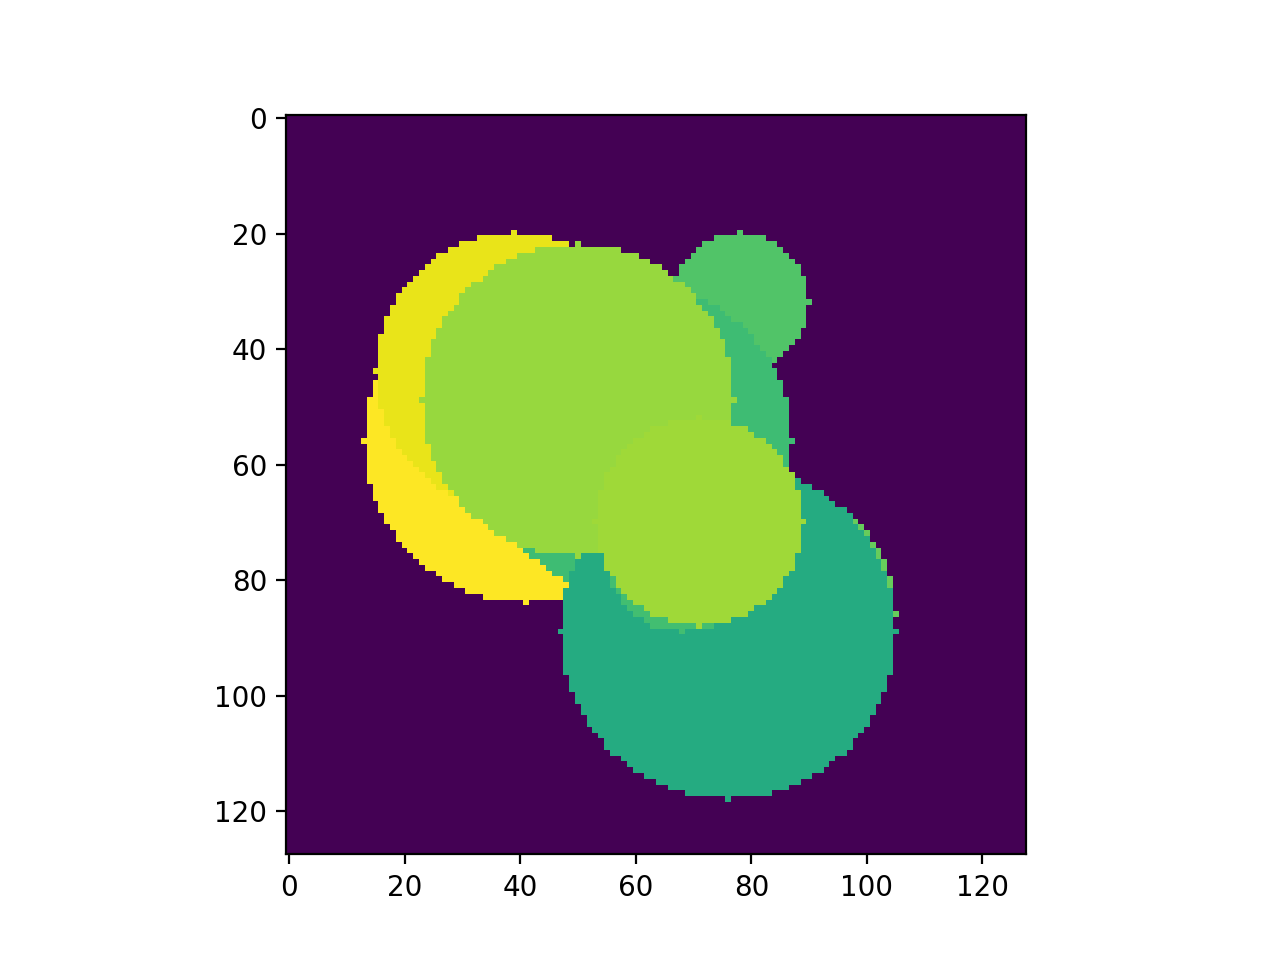

In [15]:
plt.imshow(test_dataset[1][0][0])